In [1]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, to_tree, ClusterNode
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
import os
from itertools import accumulate
from math import floor
from pandas.tseries.offsets import MonthEnd
import plotting 
from matplotlib.colors import LogNorm, Normalize
from  matplotlib import colormaps as cmaps 
import matplotlib.patches as mpatches
from matplotlib import colors
from os import path
import json

In [2]:
_HOME_ = path.expanduser("~") + "/PHD"
import modify_dataset

In [168]:
phyto_abundances = pd.read_csv(_HOME_ + "/MSFD/Data/Modulo1/phyto_abund_modified.csv", index_col=0)
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])
with open(_HOME_ + "/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params
phyto_abund_simplified = modify_dataset.make_simplified_dataset(phyto_abundances, 0.7)
phyto_abund_simplified = modify_dataset.add_season_column(phyto_abund_simplified, seasons)
phyto_abund_simplified = modify_dataset.add_coast_dist_column(phyto_abund_simplified)
phyto_abund_simplified["Date"] = pd.to_datetime(phyto_abund_simplified["Date"]) + MonthEnd(0)
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = ordered_regions, ordered = True)
taxonomic_tree = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Phyto_taxonomic_tree.xlsx")
taxonomic_tree.drop_duplicates(inplace=True)
phyto_abund_simplified = phyto_abund_simplified.merge(taxonomic_tree.loc[:,["ScientificName", "Genus", "Class"]], how = "left", left_on="Taxon", right_on="ScientificName")
phyto_abund_simplified["Class"] = phyto_abund_simplified["Class"].astype(str)
phyto_abund_simplified = modify_dataset.add_det_level_column(phyto_abund_simplified)
phyto_abund_simplified = phyto_abund_simplified.loc[:,
                                                    ["Region", "id", "Longitude", "Latitude", "Closest_coast", "Coast_dist", "Date", "Season_year", "Season", "Sample_depth", "Class", "Genus", "Det_level", "Taxon", "Num_cell_l", "file_name"]
                                                    ]
transects_info = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/transects_info.csv")
transects_info["Transect"] = transects_info["Transect"].str.upper()
phyto_abund_simplified = phyto_abund_simplified.merge(transects_info, how = "left", on = "id")

In [169]:
from_region_to_abreviation = {
    "Friuli-Venezia-Giulia" : "FVG",
    "Veneto" : "VEN", 
    "Emilia-Romagna" : "EMR",
    "Marche" : "MAR",
    "Abruzzo" : "ABR",
    "Molise" : "MOL",
    "Puglia" : "PUG",
    "Basilicata" : "BAS",
    "Calabria" : "CAL",
    "Campania" : "CAM", 
    "Lazio" : "LAZ",
    "Toscana" : "TOS",
    "Liguria" : "LIG",
     "Sicilia" : "SIC",
    "Sardegna" : "SAR"
}

In [170]:
phyto_abund_simplified["Region"] = phyto_abund_simplified["Region"].map(from_region_to_abreviation)

In [171]:
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = list(from_region_to_abreviation.values()), ordered = True)

In [172]:
from_region_to_zone = {
    "FVG" : "NorthAdr", 
    "VEN" : "NorthAdr",
    "EMR" : "NorthAdr",
    "MAR" : "NorthAdr",
    "ABR" : "SouthAdr",
    "MOL" : "SouthAdr",
    "PUG" : "SouthAdr",
    "BAS" : "Ion",
    "CAL" : "Ion",
    "CAM" : "SouthTyr", 
    "LAZ" : "SouthTyr",
    "TOS" : "Lig", 
    "LIG" : "Lig",
    "SIC" : "Ion",
    "SAR" : "WestMed"
}

In [173]:
phyto_abund_simplified["Basin"] = phyto_abund_simplified["Region"].map(from_region_to_zone)

In [174]:
phyto_abund_simplified.loc[phyto_abund_simplified["Transect"].isin(["PORTO_CESAREO", "PUNTA_RONDINELLA"]), "Basin"] = "Ion"
phyto_abund_simplified.loc[phyto_abund_simplified["Transect"].isin(["SAN_MARCO", "CAPO_GALLO", "ISOLE_EGADI"]), "Basin"] = "SouthTyr"
phyto_abund_simplified.loc[phyto_abund_simplified["Transect"].isin(["M1RM03", "M1VT04"]), "Basin"] = "Lig"
phyto_abund_simplified.loc[phyto_abund_simplified["Transect"].isin(["OLBIA", "ARBATAX", "CAGLIARI", "VILLASIMIUS"]), "Basin"] = "SouthTyr"

In [175]:
phyto_abund_simplified["Basin"] = pd.Categorical(phyto_abund_simplified["Basin"], categories = ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed"], ordered = True)

In [176]:
phyto_abund_simplified.loc[phyto_abund_simplified["Taxon"] == 'Pseudo-nitzschia spp. del nitzschia delicatissima complex', "Taxon"] = 'Nitzschia delicatissima complex'
phyto_abund_simplified.loc[phyto_abund_simplified["Taxon"] == 'Pseudo-nitzschia spp. del nitzschia seriata complex', "Taxon"] = 'Nitzschia seriata complex'

# First part

In [12]:
phyto_abund_simplified.query("Taxon != 'Other phytoplankton' and Det_level == 'Species'")[["Class", "Taxon"]].groupby("Class").nunique().sort_values("Taxon", ascending = False).to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/phyto_classes.csv")

In [13]:
phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby("Taxon").count()["Num_cell_l"].quantile(np.arange(0, 1.05, 0.05))

0.00       1.00
0.05       1.00
0.10       1.00
0.15       1.00
0.20       2.00
0.25       3.00
0.30       4.00
0.35       5.00
0.40       7.00
0.45       8.25
0.50      12.00
0.55      16.00
0.60      22.00
0.65      30.00
0.70      44.00
0.75      63.00
0.80      90.00
0.85     131.25
0.90     216.50
0.95     416.50
1.00    1380.00
Name: Num_cell_l, dtype: float64

In [153]:
phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby("Taxon").count()[["Num_cell_l"]].query("Num_cell_l >416 ").sort_values(ascending=False, by = "Num_cell_l").to_csv(
    _HOME_ + "/ISPRA_20152017_Analysis/Description/Taxa_freq_95.csv")

In [12]:
freq_taxa = phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby("Taxon").count()[["Num_cell_l"]].query("Num_cell_l >= 416 ").sort_values(ascending=False, by = "Num_cell_l").index

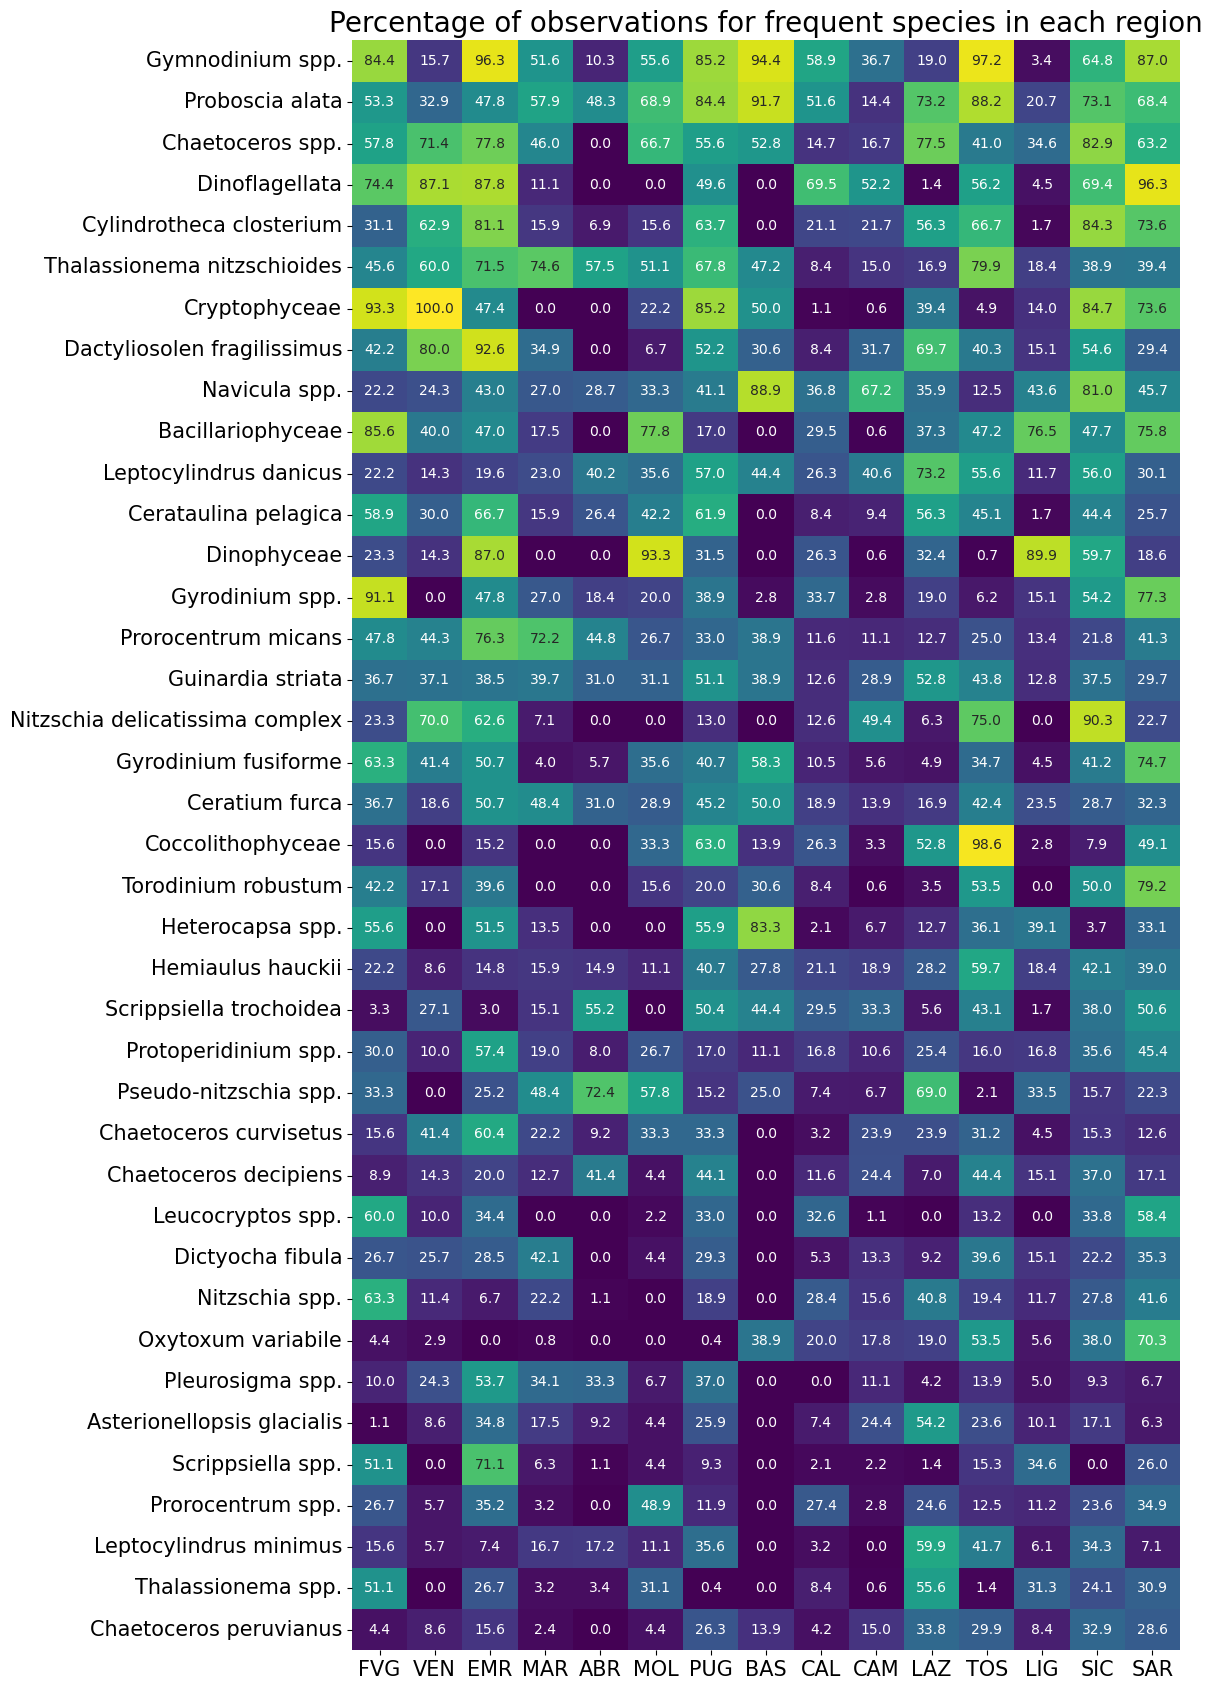

In [187]:
pres_abs = phyto_abund_simplified.query("Taxon in @freq_taxa").pivot_table(
    index= ["Region", "Date", "id"], 
    columns="Taxon",
    values="Num_cell_l",
    aggfunc="mean",
    fill_value=0
) > 0
pres_abs.reset_index(inplace=True)
n_region_samples = pres_abs.drop_duplicates(["Date", "id"]).groupby("Region", observed=True).count()["id"].to_numpy()
fig, ax = plt.subplots(figsize=(12, 17))

sns.heatmap(
data = pres_abs.groupby("Region", observed=True).sum(numeric_only=True).apply(lambda x: x / n_region_samples, axis=0).T.loc[freq_taxa, :] * 100, 
cmap = "viridis",
annot=True,
fmt=".1f",
ax = ax, 
cbar=False
)
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size = 15);
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Percentage of observations for frequent species in each region", fontsize = 20)
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_freq_95_heatmap.png", dpi = 300, bbox_inches = "tight")

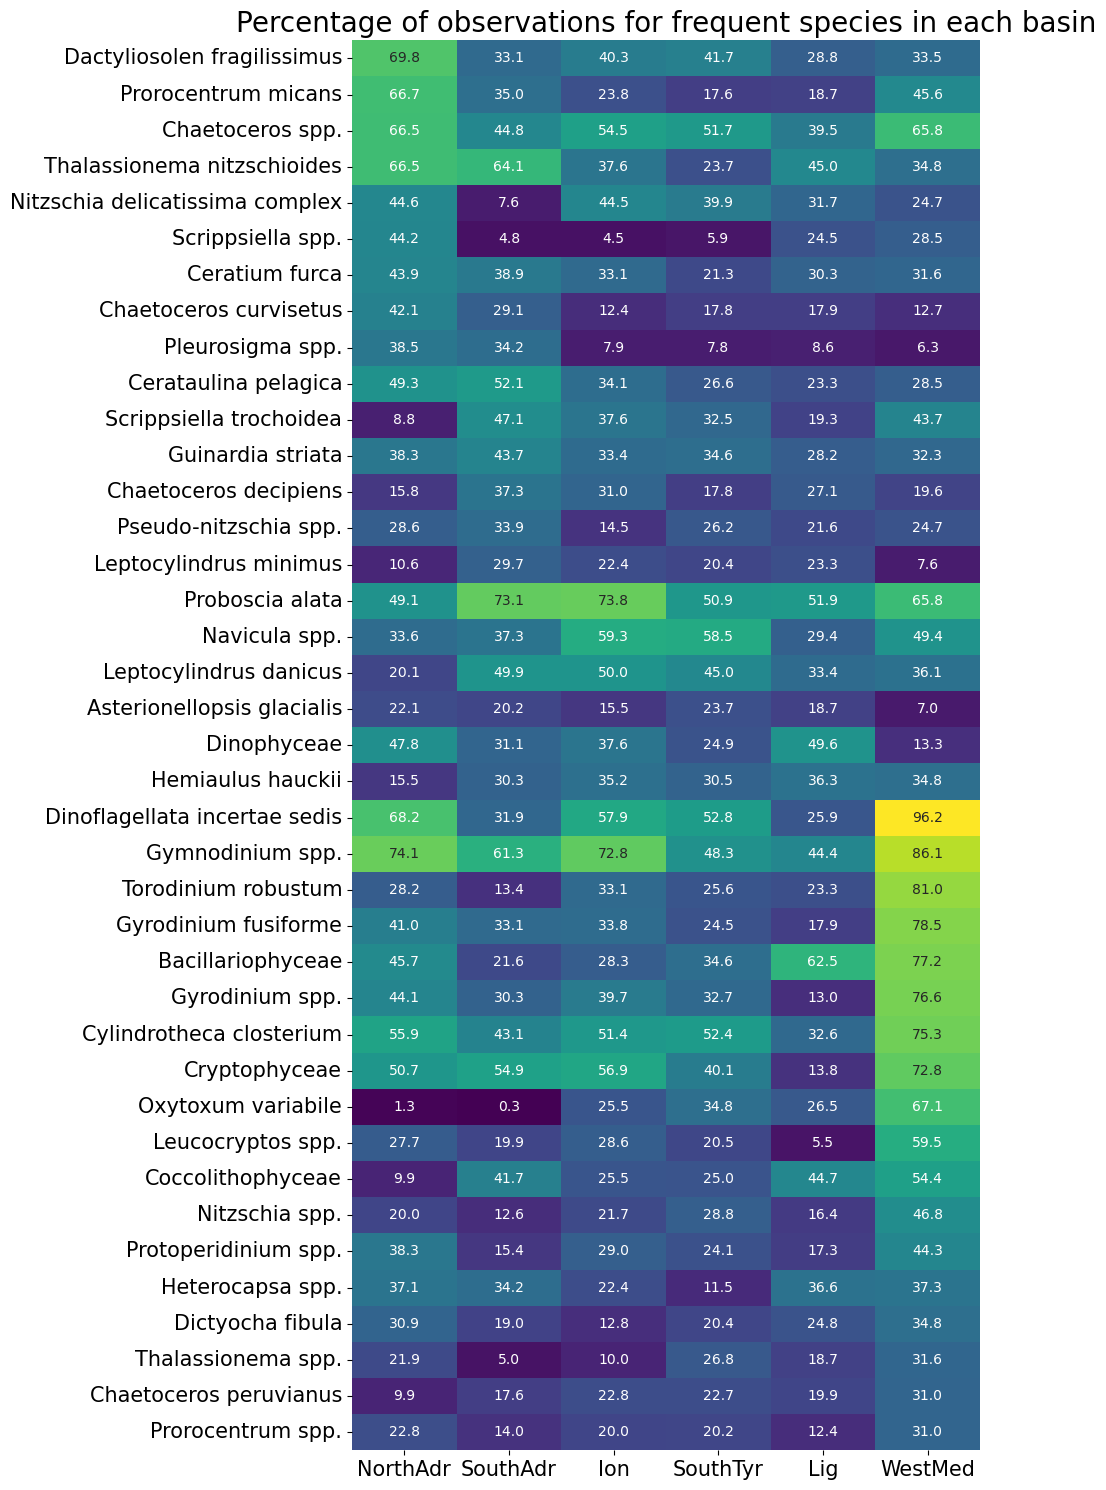

In [46]:
pres_abs = phyto_abund_simplified.query("Taxon in @freq_taxa").pivot_table(
    index= ["Basin", "Date", "id"], 
    columns="Taxon",
    values="Num_cell_l",
    aggfunc="mean",
    fill_value=0
) > 0
pres_abs.reset_index(inplace=True)
n_Basin_samples = pres_abs.drop_duplicates(["Date", "id"]).groupby("Basin", observed=True).count()["id"].to_numpy()
pres_abs = pres_abs.groupby("Basin", observed=True).sum(numeric_only=True).apply(lambda x: x / n_Basin_samples, axis=0).T.loc[freq_taxa, :] * 100
pres_abs_long = pres_abs.reset_index().melt(id_vars = "Taxon", var_name = "Basin", value_name = "Freq")
pres_abs_long["Basin"] = pd.Categorical(pres_abs_long["Basin"], categories = ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed"], ordered = True)
idx = pres_abs_long.groupby("Taxon")["Freq"].idxmax()
ordered_ids = pres_abs_long.loc[idx].sort_values(["Basin", "Freq"], ascending=[True, False])["Taxon"]


fig, ax = plt.subplots(figsize=(10, 15))
sns.heatmap(
data = pres_abs.loc[ordered_ids, :], 
cmap = "viridis",
annot=True,
fmt=".1f",
ax = ax, 
cbar=False
)
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size = 15);
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Percentage of observations for frequent species in each basin", fontsize = 20)
plt.tight_layout()
#plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_freq_95_heatmap_per_basin.png", dpi = 300, bbox_inches = "tight")

In [47]:
data = phyto_abund_simplified.groupby("Taxon").sum(numeric_only=True).sort_values("Num_cell_l", ascending = False)
data["Percent_cumsum"] = data["Num_cell_l"].cumsum() / data["Num_cell_l"].sum()
data["Percen_abund"] = data["Num_cell_l"] / data["Num_cell_l"].sum() * 100

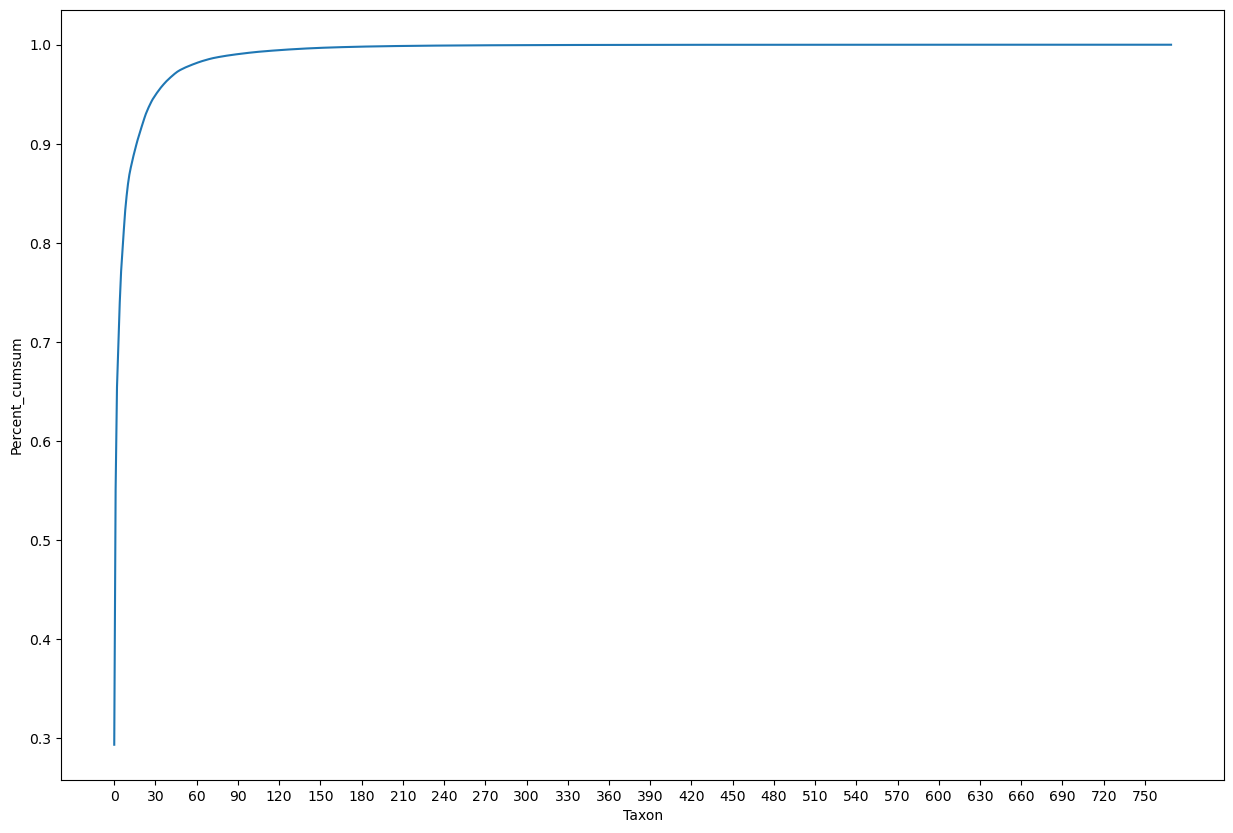

In [29]:
fig, ax = plt.subplots(figsize=(15, 10))

#.query("Taxon != 'Other phytoplankton'")

sns.lineplot(
    x = "Taxon",
    y = "Percent_cumsum",
    data = data,
    ax = ax
)
ax.set_xticks(np.arange(0, len(data), 30));
ax.set_xticklabels(np.arange(0, len(data), 30));

In [65]:
abund_taxa = data.query("Percent_cumsum <= 0.95")["Percen_abund"].index

In [66]:
data.query("Percent_cumsum <= 0.95")["Percen_abund"].to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_abund_95.csv")

In [159]:
rel_taxa = set(freq_taxa).union(set(abund_taxa))

In [172]:
phyto_abund_simplified.groupby("Region", observed=True).nunique()[["Taxon"]]

,Taxon
Region,
FVG,221
VEN,146
EMR,290
MAR,227
ABR,107
MOL,113
PUG,378
BAS,75
CAL,209


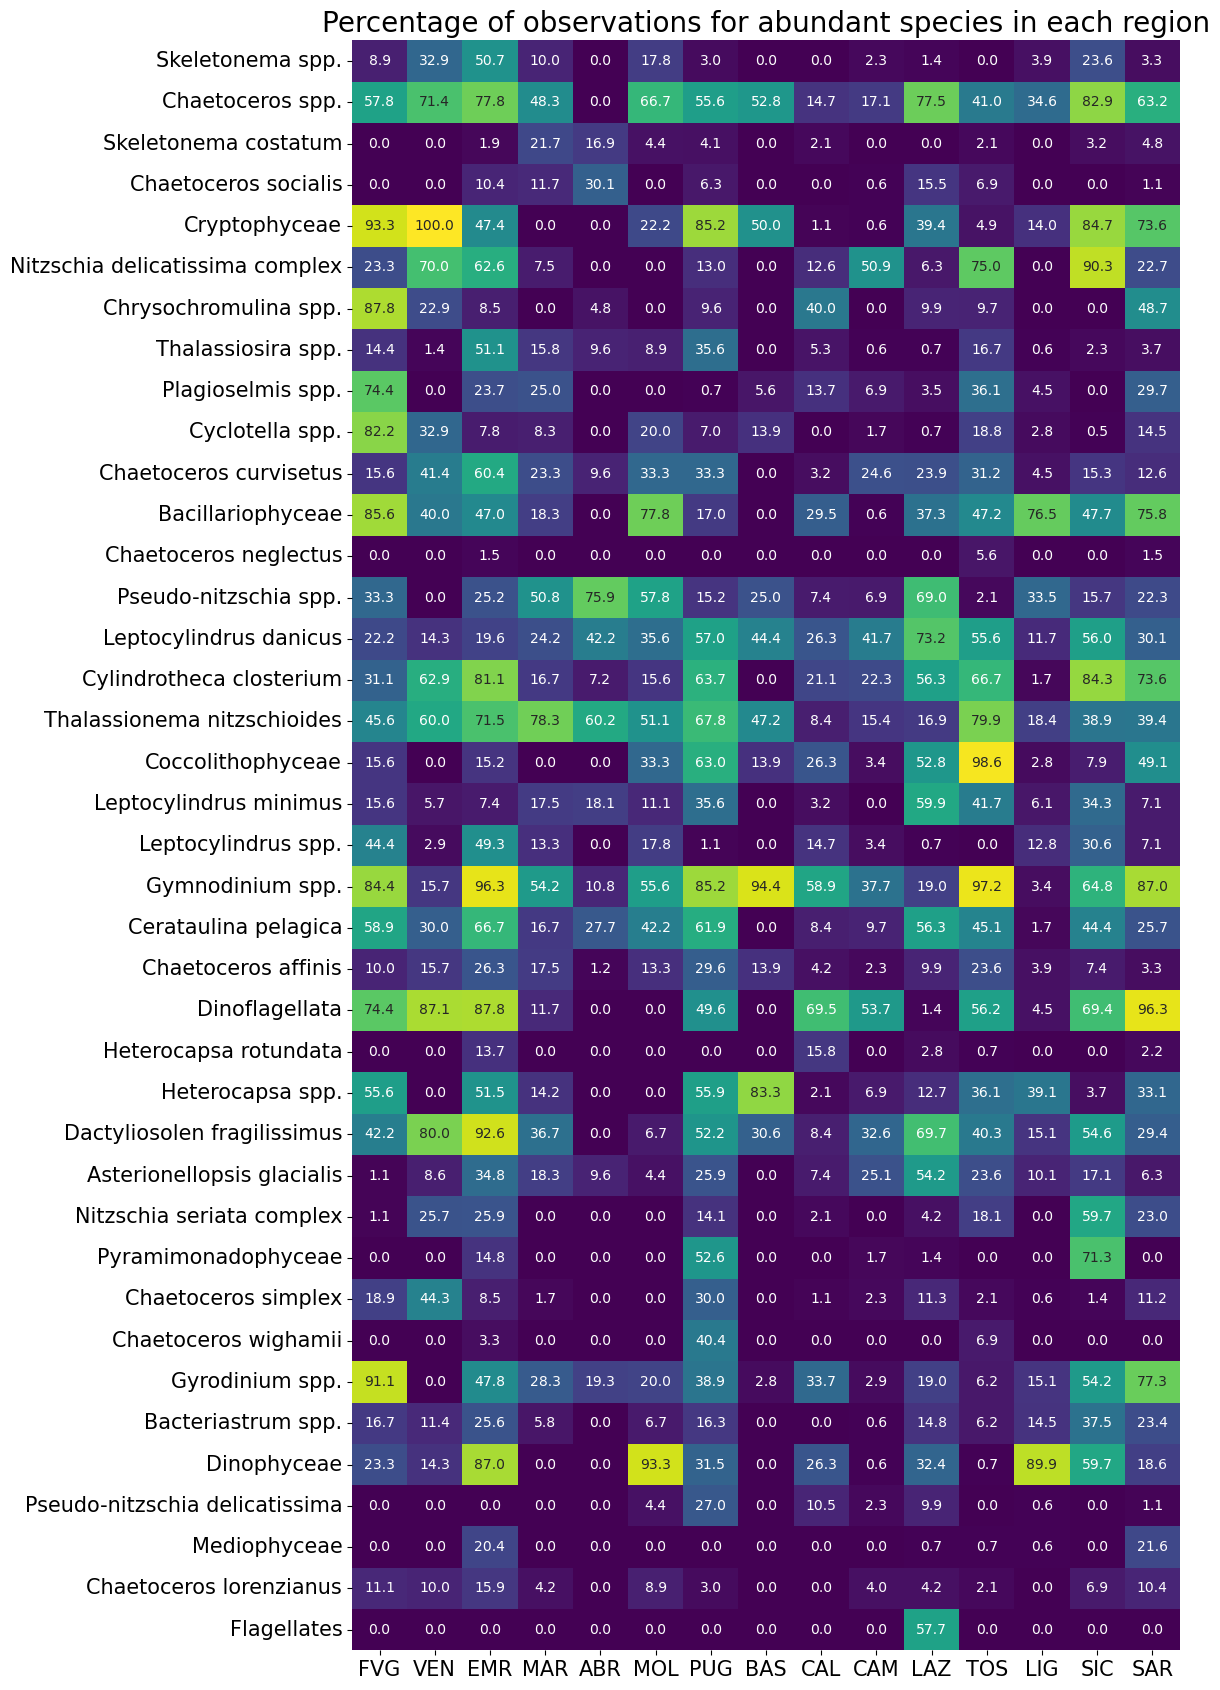

In [190]:
pres_abs = phyto_abund_simplified.query("Taxon in @abund_taxa").pivot_table(
    index= ["Region", "Date", "id"], 
    columns="Taxon",
    values="Num_cell_l",
    aggfunc="mean",
    fill_value=0
) > 0
pres_abs.reset_index(inplace=True)
n_region_samples = pres_abs.drop_duplicates(["Date", "id"]).groupby("Region", observed=True).count()["id"].to_numpy()

fig, ax = plt.subplots(figsize=(12, 17))

sns.heatmap(
data = pres_abs.groupby("Region", observed=True).sum(numeric_only=True).apply(lambda x: x / n_region_samples, axis=0).T.loc[abund_taxa, :] * 100, 
cmap = "viridis",
annot=True,
fmt=".1f",
ax = ax, 
cbar=False
)
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size = 15);
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Percentage of observations for abundant species in each region", fontsize = 20)
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_abund_95_heatmap.png", dpi = 300, bbox_inches = "tight")

/tmp/ipykernel_33270/3468558808.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pres_abs = phyto_abund_simplified.query("Taxon in @abund_taxa").pivot_table(


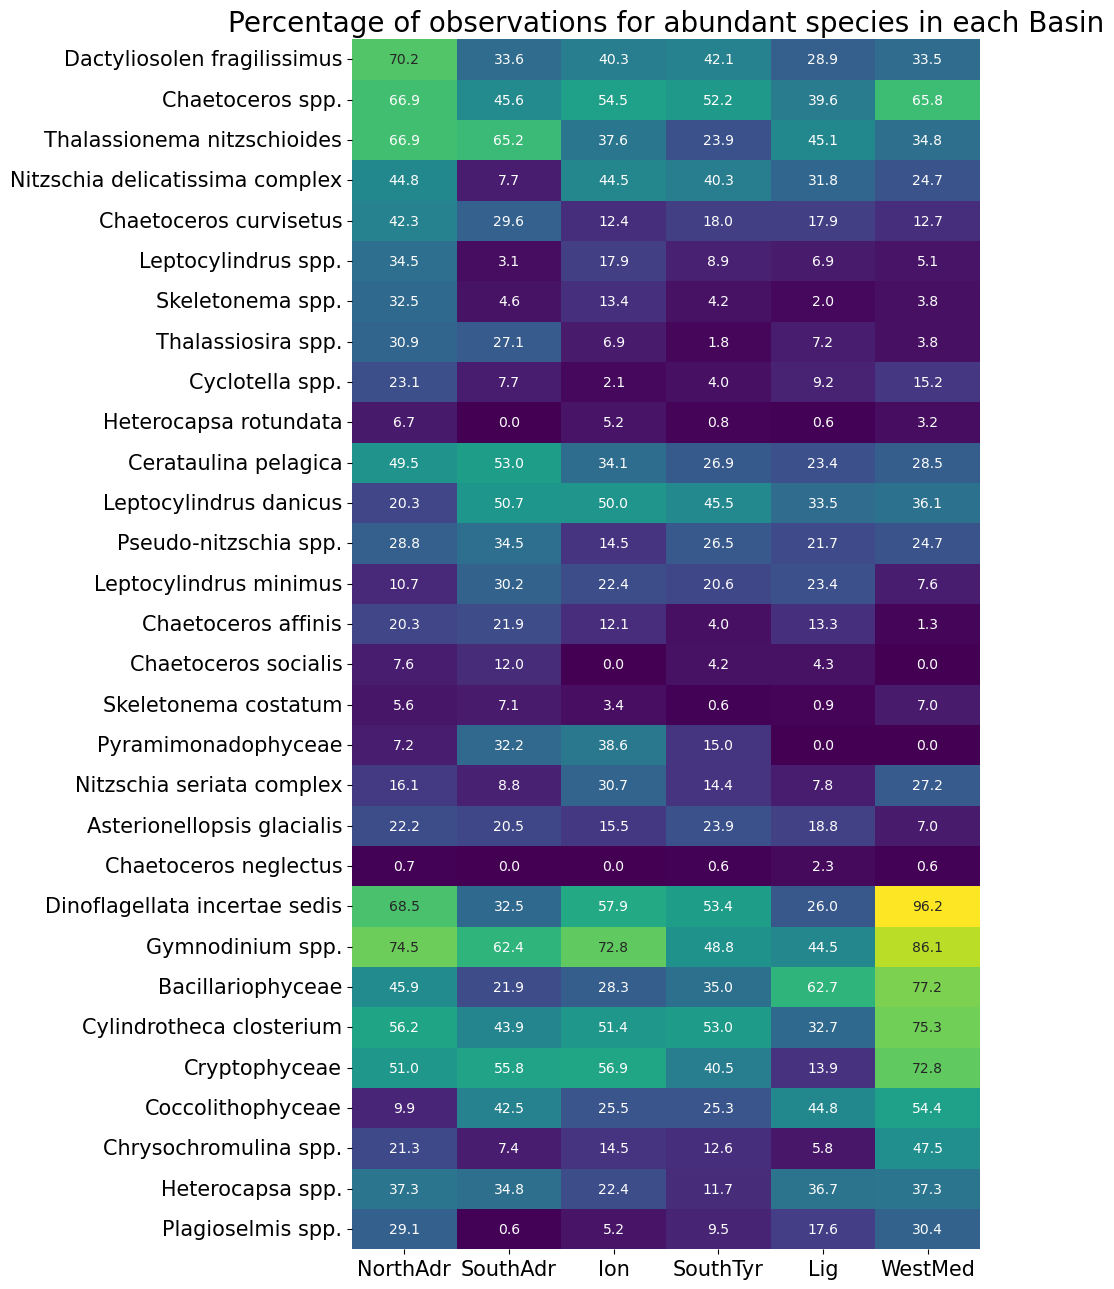

In [56]:
pres_abs = phyto_abund_simplified.query("Taxon in @abund_taxa").pivot_table(
    index= ["Basin", "Date", "id"], 
    columns="Taxon",
    values="Num_cell_l",
    aggfunc="mean",
    fill_value=0
) > 0
pres_abs.reset_index(inplace=True)
n_Basin_samples = pres_abs.drop_duplicates(["Date", "id"]).groupby("Basin", observed=True).count()["id"].to_numpy()
pres_abs = pres_abs.groupby("Basin", observed=True).sum(numeric_only=True).apply(lambda x: x / n_Basin_samples, axis=0).T.loc[abund_taxa[1:], :] * 100
pres_abs_long = pres_abs.reset_index().melt(id_vars = "Taxon", var_name = "Basin", value_name = "Freq")
pres_abs_long["Basin"] = pd.Categorical(pres_abs_long["Basin"], categories = ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed"], ordered = True)
idx = pres_abs_long.groupby("Taxon")["Freq"].idxmax()
ordered_ids = pres_abs_long.loc[idx].sort_values(["Basin", "Freq"], ascending=[True, False])["Taxon"]


fig, ax = plt.subplots(figsize=(10, 13))

sns.heatmap(
data = pres_abs.loc[ordered_ids, :], 
cmap = "viridis",
annot=True,
fmt=".1f",
ax = ax, 
cbar=False
)
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size = 15);
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Percentage of observations for abundant species in each Basin", fontsize = 20)
plt.tight_layout()
#plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_abund_95_heatmap_per_basin.png", dpi = 300, bbox_inches = "tight")

In [315]:
phyto_abund_simplified.loc[:, ["id", "Basin"]].drop_duplicates().to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Station_basin.csv", index=False)

In [317]:
indval = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/indval_per_basin.csv", )

In [321]:
import re
indval.iloc[:, 0] = indval.iloc[:, 0].apply(lambda x: re.sub(r'\.(?!$)', ' ', x))

In [324]:
np.sort(abund_taxa.intersection(set(indval.iloc[:, 0])))

array(['Bacillariophyceae', 'Cerataulina pelagica',
       'Chaetoceros curvisetus', 'Chaetoceros spp.', 'Coccolithophyceae',
       'Cylindrotheca closterium', 'Dactyliosolen fragilissimus',
       'Gymnodinium spp.', 'Gyrodinium spp.', 'Leptocylindrus spp.',
       'Skeletonema spp.', 'Thalassionema nitzschioides',
       'Thalassiosira spp.'], dtype=object)

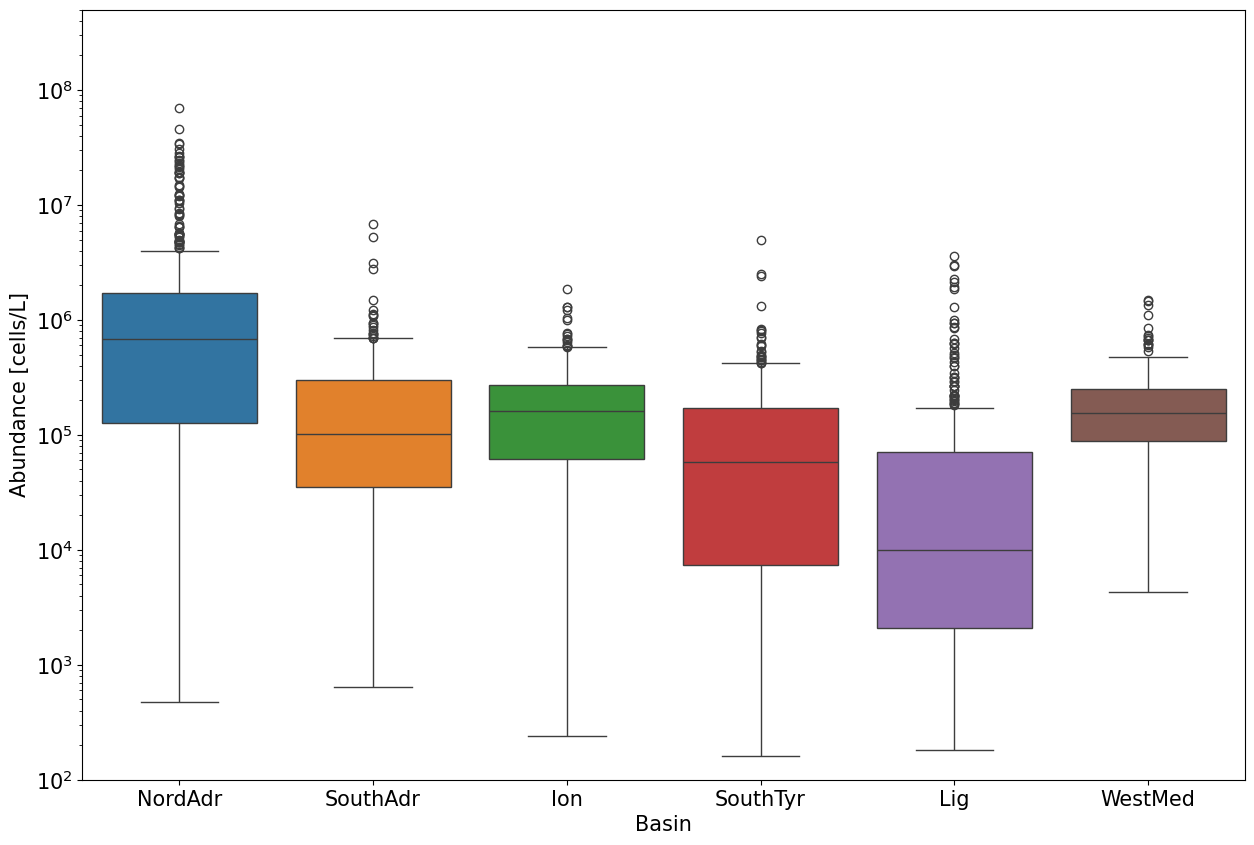

In [31]:
fig, ax = plt.subplots(figsize=(15, 10))

abund = phyto_abund_simplified.groupby(["Date", "id"]).agg(
    {"Num_cell_l" : "sum", 
     "Basin" : "first",
     }
)

sns.boxplot(
    x = "Basin",
    y = "Num_cell_l",
    data = abund,
    hue = "Basin",
    ax = ax
)
ax.set_yscale("log")
ax.set_ylabel("Abundance [cells/L]", size = 15)
ax.set_xlabel("Basin", size = 15)
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), size = 15);
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), size = 15);
ax.set_ylim(1e2, 5 * 1e8)
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Abundance_per_basin.png", dpi = 300, bbox_inches = "tight")

In [55]:
"Heterocapsa niei" in phyto_abund_simplified["Taxon"].to_list()

True

In [63]:
phyto_abund_simplified.loc[phyto_abund_simplified["Taxon"].str.contains("hydroideus"), "Taxon"].unique()

array(['Ophiaster hydroideus'], dtype=object)

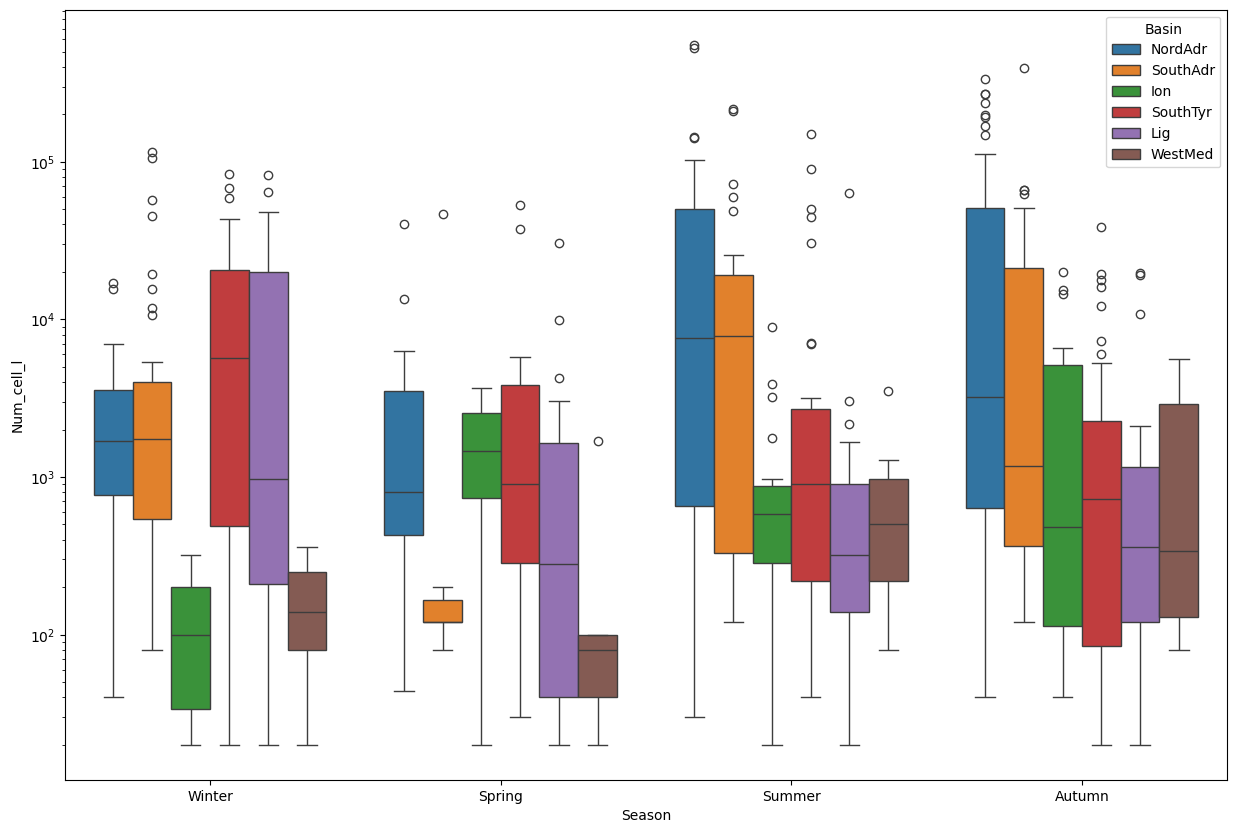

In [71]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.boxplot(
    data = phyto_abund_simplified.query("Taxon == 'Pseudo-nitzschia spp.'"), 
    x = "Season",
    y = "Num_cell_l", 
    hue = "Basin"
)
ax.set_yscale("log")

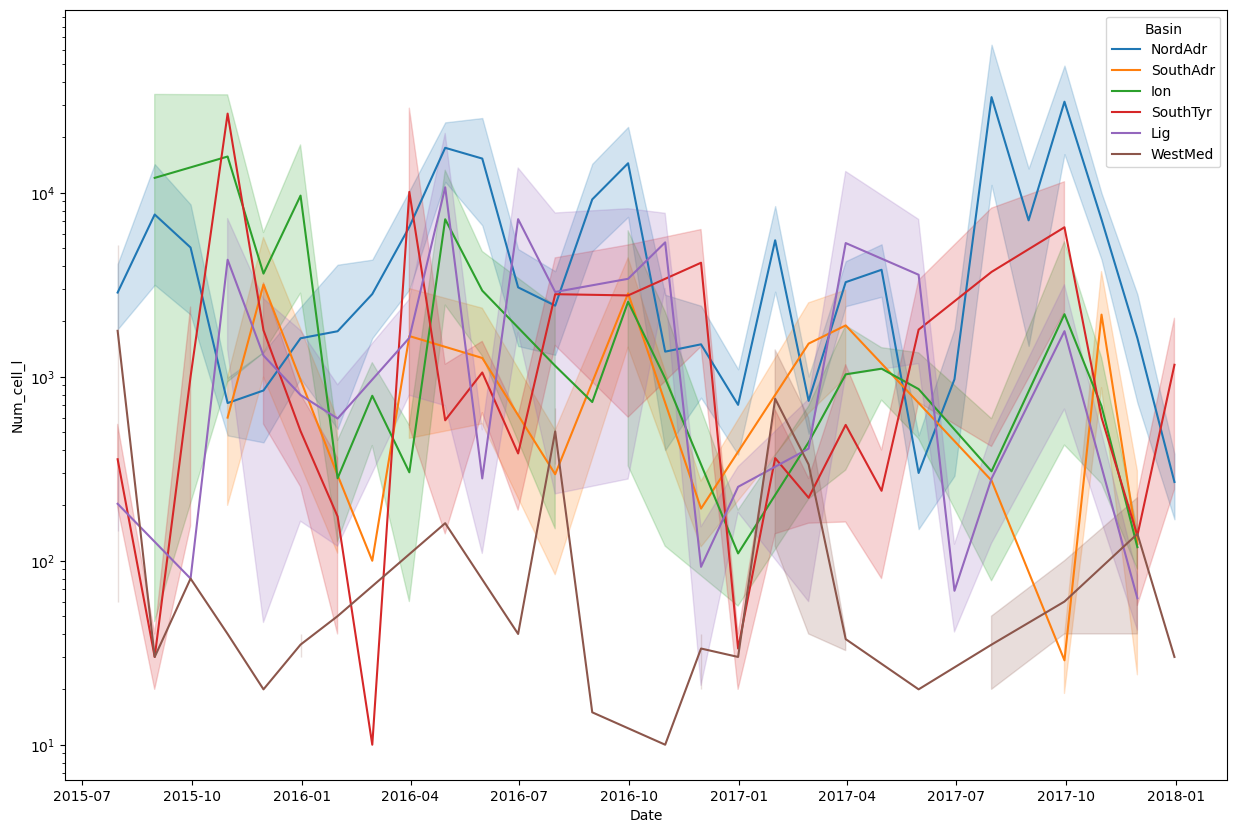

In [53]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.lineplot(
    data = phyto_abund_simplified.query("Taxon == 'Dactyliosolen fragilissimus'"), 
    x = "Date",
    y = "Num_cell_l", 
    hue = "Basin"
)
ax.set_yscale("log")

# Second Part

In [17]:
phyto_abund_simplified.query("Det_level == 'Species'").groupby("Taxon").count().sort_values("Region")["Region"].quantile(0.95)

331.55000000000007

In [22]:
phyto_abund_simplified.query("Det_level == 'Species'").groupby("Taxon").count()[["Region"]].sort_values("Region", ascending = False).query("Region > 332").to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_freq_top.csv")

In [27]:
phyto_abund_simplified.drop_duplicates(["Date", "id", "Genus"]).groupby("Genus").count()[["Region"]].quantile(0.95)

Region    1052.8
Name: 0.95, dtype: float64

In [28]:
phyto_abund_simplified.drop_duplicates(["Date", "id", "Genus"]).groupby("Genus").count()[["Region"]].sort_values("Region", ascending = False).query("Region > 1052").to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Genera_freq_top.csv")

In [29]:
phyto_abund_simplified["Det_level"].unique()

array(['Species', 'Genus', 'Higher cat.', 'Unknown'], dtype=object)

In [31]:
phyto_abund_simplified.drop_duplicates(["Date", "id", "Class"]).groupby("Class").count()[["Region"]].quantile(0.95)

Region    1945.6
Name: 0.95, dtype: float64

In [34]:
phyto_abund_simplified.drop_duplicates(["Date", "id", "Class"]).groupby("Class").count()[["Region"]].sort_values("Region", ascending = False).iloc[:12].to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Classes_freq_top.csv")

In [67]:
abund_taxa = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_abund_95.csv").query("Taxon != 'Other phytoplankton'")["Taxon"].to_list()

In [68]:
abund_per_basin = phyto_abund_simplified.groupby(
    "Basin", observed=True
).sum(numeric_only=True)[["Num_cell_l"]]

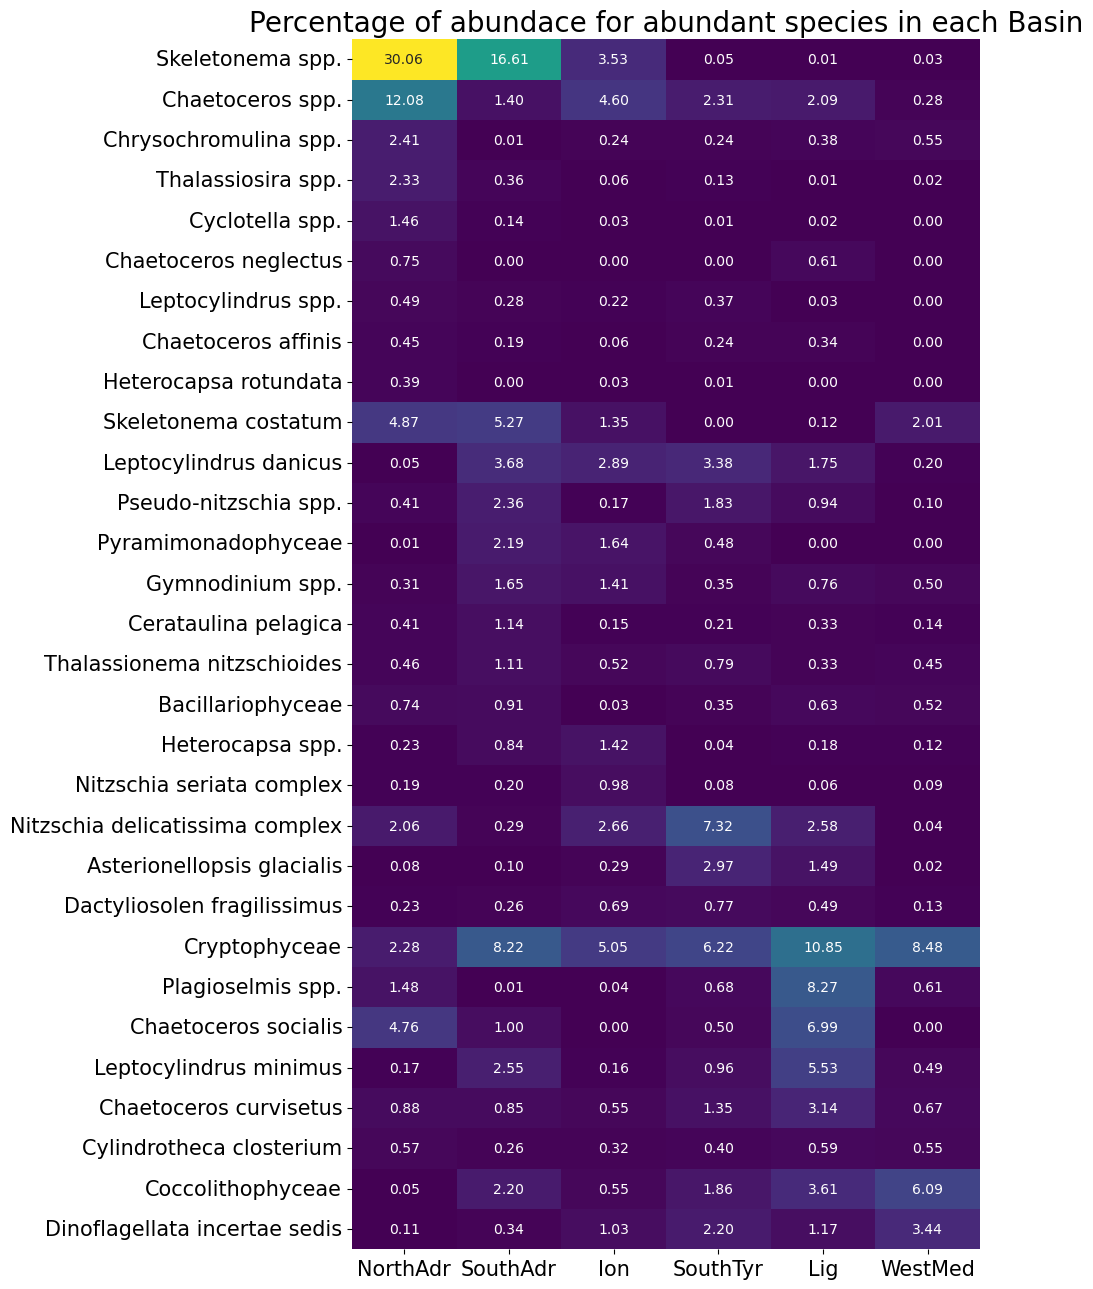

In [71]:
abund_distribution = phyto_abund_simplified.query("Taxon in @abund_taxa").groupby(["Taxon", "Basin"], observed=True).sum(numeric_only=True)[["Num_cell_l"]].pivot_table(index="Taxon", columns="Basin", values="Num_cell_l", fill_value=0).loc[abund_taxa,:] / abund_per_basin.T.to_numpy() * 100
abund_distribution_long = abund_distribution.reset_index().melt(id_vars="Taxon", var_name="Basin", value_name="Freq")
abund_distribution_long["Basin"] = pd.Categorical(abund_distribution_long["Basin"], categories=["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed"], ordered=True)
idx = abund_distribution_long.groupby("Taxon")["Freq"].idxmax()
ordered_ids = abund_distribution_long.loc[idx].sort_values(["Basin", "Freq"], ascending=[True, False])["Taxon"]

fig, ax = plt.subplots(figsize=(10, 13))

sns.heatmap(
data = abund_distribution.loc[ordered_ids, :], 
cmap = "viridis",
annot=True,
fmt=".2f",
ax = ax, 
cbar=False
)
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size = 15);
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Percentage of abundace for abundant species in each Basin", fontsize = 20)
plt.tight_layout()
#plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_abund_distribution_heatmap_per_basin.png", dpi = 300, bbox_inches = "tight")

In [77]:
IndVal = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/indval_along_basins.csv", index_col=0)

In [78]:
import re
IndVal.index = list(map(lambda x: re.sub(r'\.(?!$)', ' ', x), IndVal.index))
IndVal.index.name = "Taxon"

In [79]:
IndVal.rename(columns= {"NordAdr": "NorthAdr"}, inplace=True)

In [81]:
IndVal_long = IndVal.reset_index().melt(id_vars="Taxon", var_name="Basin", value_name="IndVal")
IndVal_long["Basin"] = pd.Categorical(IndVal_long["Basin"], categories=["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed"], ordered=True)
idx = IndVal_long.groupby("Taxon")["IndVal"].idxmax()
ordered_ids = IndVal_long.loc[idx].sort_values(["Basin", "IndVal"], ascending=[True, False])["Taxon"]

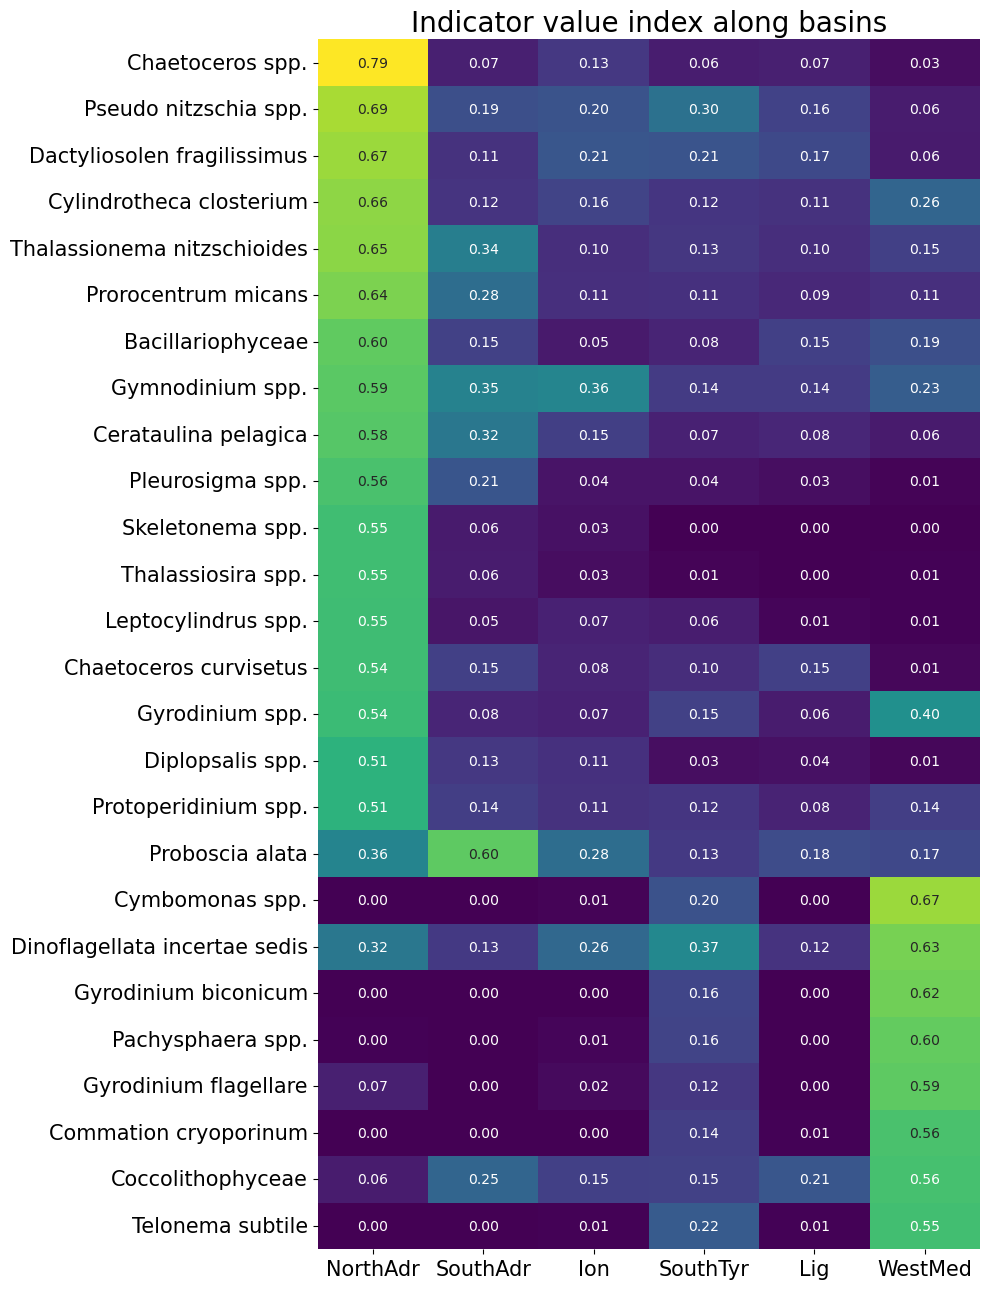

In [83]:
fig, ax = plt.subplots(figsize=(10, 13))

sns.heatmap(
data = IndVal.loc[ordered_ids, :], 
cmap = "viridis",
annot=True,
fmt=".2f",
ax = ax, 
cbar=False
)
ax.set_yticks(ax.get_yticks());
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, size = 15);
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Indicator value index along basins", fontsize = 20)
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_indval_per_basin.png", dpi = 300, bbox_inches = "tight")

In [94]:
mean_abund = phyto_abund_simplified.groupby(["Basin", "Taxon"], observed=True).mean(numeric_only=True)[["Num_cell_l"]].sort_values("Num_cell_l", ascending = False)

In [92]:
mean_abund.apply(lambda x: x / mean_abund.sum(), axis=1).head(20)

,Num_cell_l
Taxon,
Skeletonema spp.,0.254978
Skeletonema costatum,0.141262
Chaetoceros neglectus,0.105204
Chaetoceros socialis,0.091387
Other phytoplankton,0.045399
Chaetoceros spp.,0.023102
Chaetoceros delicatulus,0.019471
Chaetoceros radicans,0.016403
Thalassiosira spp.,0.015950


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [7]:
world = gpd.read_file(_HOME_ + "/ISPRA_20152017_Analysis/Description/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")

In [41]:
italy = world.query("admin == 'Italy'").dissolve(by = "region", aggfunc="sum")

In [157]:
near_countries = ["France", "Switzerland", "Austria", "Slovenia", "Croatia", "Montenegro", "Bosnia and Herzegovina", "Albania", "Greece", "Austria", "Hungary", "Serbia", "Tunisia", "Algeria"]

In [158]:
gdf_surrounding = world.query("admin in @near_countries").dissolve(by = "admin", aggfunc="sum")

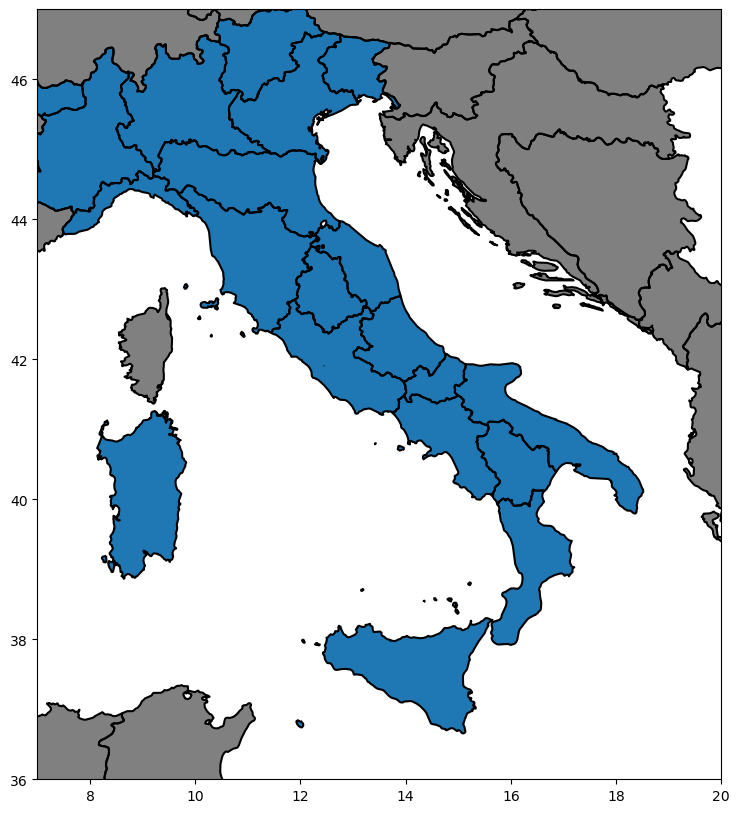

In [159]:
fig, ax = plt.subplots(figsize=(10, 10))

italy.boundary.plot(ax=ax, color='black')
#italy_countries.plot(column = "name_alt", ax=ax)
gdf_surrounding.plot(ax = ax, color = "grey")
gdf_surrounding.boundary.plot(ax = ax, color = "black")
italy.plot(ax = ax)
ax.set_xlim(7,20)
ax.set_ylim(36,47)

# Show the plot
plt.show()

In [62]:
import xarray as xr

In [63]:
basins = xr.open_dataset(_HOME_ + "/ISPRA_20152017_Analysis/Description/sub.nc")

In [120]:
df_basins = basins.to_dataframe().reset_index()

In [123]:
df_basins.loc[:, ["longitude", "latitude"]] = df_basins.loc[:, ["longitude", "latitude"]] + 0.5 / 24

In [124]:

gdf_basin = gpd.GeoDataFrame(df_basins, geometry=gpd.points_from_xy(df_basins.longitude, df_basins.latitude))

In [125]:
xlim = (7, 20)
ylim = (36, 47)
gdf_basin = gdf_basin.cx[xlim[0]:xlim[1], ylim[0]:ylim[1]]

In [128]:
gdf_basin.loc[:, "sub_number"] = gdf_basin.loc[:, "sub_number"].fillna(0).astype(int).astype(str)

/tmp/ipykernel_4930/3037448106.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0' '0' '0' ... '0' '0' '0']' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  gdf_basin.loc[:, "sub_number"] = gdf_basin.loc[:, "sub_number"].fillna(0).astype(int).astype(str)


In [142]:
basin_center = gdf_basin.dissolve("sub_number", aggfunc="mean").reset_index().query("sub_number !='0'")

In [143]:
basin_center["geometry"] = basin_center["geometry"].geometry.centroid

1 12.827165322281752
2 17.507433722211147
3 17.95783331327253
4 8.060790228891026
5 7.997093054795452
6 10.510558303805778
7 12.307684566679157
8 14.572479931391698
9 17.652387440587585


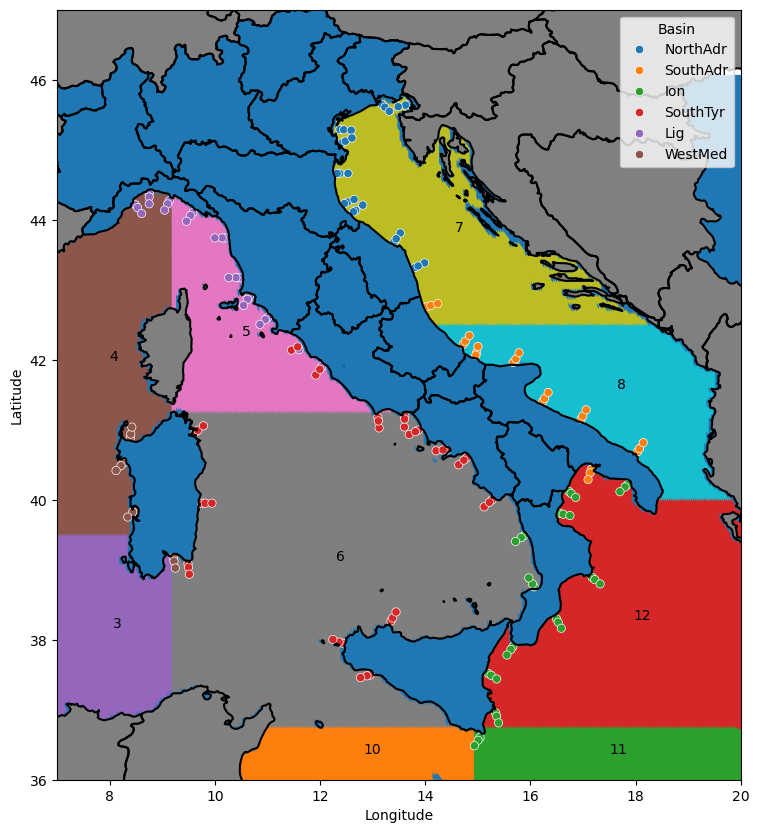

In [179]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_basin.plot("sub_number", ax = ax)
italy.boundary.plot(ax=ax, color='black')
gdf_surrounding.plot(ax = ax, color = "grey")
gdf_surrounding.boundary.plot(ax = ax, color = "black")
italy.plot(ax = ax)
sns.scatterplot(data = phyto_abund_simplified.loc[:, ["Longitude", "Latitude", "Basin"]].drop_duplicates(), x = "Longitude", y = "Latitude", ax = ax, hue = "Basin")
for idx, row in basin_center.iterrows(): 
    ax.text(row["geometry"].x, row["geometry"].y, row["sub_number"], fontsize = 10)
ax.set_xlim(7,20)
ax.set_ylim(36,47)

# Show the plot
plt.show()

In [161]:
from shapely.geometry import box
from shapely.ops import unary_union

(36.0, 46.0)

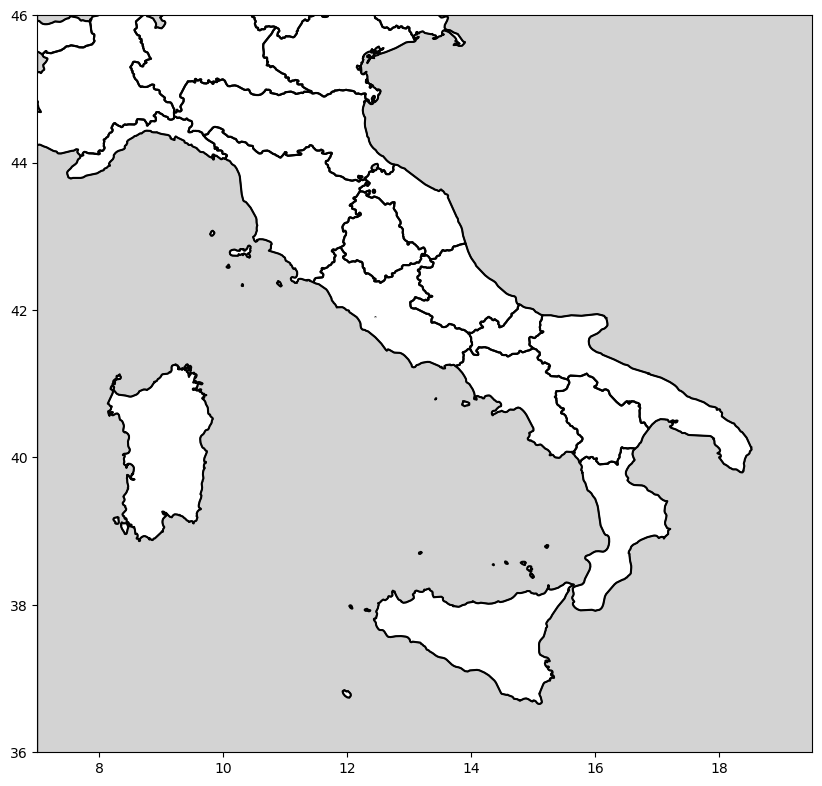

In [165]:
# Define the bounding box limits
x_min, x_max = 7, 19.5
y_min, y_max = 36, 46

bounding_box = box(x_min, x_max, y_min, y_max)

# Combine all geometries in italy_countries into a single geometry
italy_union = unary_union(italy.geometry)

# Subtract italy_countries geometries from the bounding box
outside_italy = bounding_box.difference(italy_union)

# Create a new GeoDataFrame with the resulting polygon
outside_italy_gdf = gpd.GeoDataFrame(geometry=[outside_italy], crs=italy.crs)

# Plot the result
fig, ax = plt.subplots(figsize=(10, 10))
italy.boundary.plot(ax=ax, color='black')
outside_italy_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)


In [92]:
from shapely.geometry import LineString, Polygon
from shapely.ops import split
x_min, x_max = 7.2, 19
y_min, y_max = 36, 46
x_intervals = [10, 12, 14, 16, 18]  # Example x intervals
y_intervals = [38, 40, 42, 44]      # Example y intervals

# Create horizontal and vertical lines
horizontal_lines = [LineString([(x_min, y), (x_max, y)]) for y in y_intervals]
vertical_lines = [LineString([(x, y_min), (x, y_max)]) for x in x_intervals]

# Combine all lines into a single MultiLineString
all_lines = horizontal_lines + vertical_lines

# Split the outside_italy_gdf polygon using the lines
split_polygons = [outside_italy_gdf.geometry[0]]
for line in all_lines:
    new_split_polygons = []
    for polygon in split_polygons:
        new_split_polygons.extend(split(polygon, line))
    split_polygons = new_split_polygons

# Convert the GeometryCollection object to a list
split_polygons = list(split_polygons)

# Create a new GeoDataFrame with the resulting polygons
split_gdf = gpd.GeoDataFrame(geometry=split_polygons, crs=outside_italy_gdf.crs)

# Plot the result
fig, ax = plt.subplots(figsize=(10, 10))
outside_italy_gdf.boundary.plot(ax=ax, color='black')
split_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.show()

TypeError: 'GeometryCollection' object is not iterable

In [ ]:
line_split_collection.append(polygon.boundary) # collection of individual linestrings for splitting in a list and add the polygon lines to it.
merged_lines = shapely.ops.linemerge(line_split_collection)
border_lines = shapely.ops.unary_union(merged_lines)
decomposition = shapely.ops.polygonize(border_lines)

In [166]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiLineString
from shapely.ops import linemerge, unary_union, polygonize
import matplotlib.pyplot as plt

# Extract the polygon from outside_italy_gdf
polygon = outside_italy_gdf.geometry.iloc[0]

# Define the coordinates for the lines to split the polygon
coords = [
    ((7.2, 38), (19, 38)),  # Horizontal line at y=38
    ((7.2, 40), (19, 40)),  # Horizontal line at y=40
    ((7.2, 42), (19, 42)),  # Horizontal line at y=42
    ((7.2, 44), (19, 44)),  # Horizontal line at y=44
    ((10, 36), (10, 46)),   # Vertical line at x=10
    ((12, 36), (12, 46)),   # Vertical line at x=12
    ((14, 36), (14, 46)),   # Vertical line at x=14
    ((16, 36), (16, 46)),   # Vertical line at x=16
    ((18, 36), (18, 46))    # Vertical line at x=18
]

# Create a MultiLineString from the coordinates
lines = MultiLineString(coords)

# Create a collection of individual linestrings for splitting
line_split_collection = [polygon.boundary] + list(lines)

# Merge the lines
merged_lines = linemerge(line_split_collection)

# Create a unary union of the merged lines
border_lines = unary_union(merged_lines)

# Decompose the polygon using the border lines
decomposition = polygonize(border_lines)

# Create a new GeoDataFrame with the resulting polygons
split_gdf = gpd.GeoDataFrame(geometry=list(decomposition), crs=outside_italy_gdf.crs)

# Plot the result
fig, ax = plt.subplots(figsize=(10, 10))
outside_italy_gdf.boundary.plot(ax=ax, color='black')
split_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')

ax.set_xlim(7.2, 19)
ax.set_ylim(36, 46)

plt.show()

TypeError: 'MultiLineString' object is not iterable

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiLineString
from shapely.ops import linemerge, unary_union, polygonize
import matplotlib.pyplot as plt

# Extract the polygon from outside_italy_gdf
polygon = outside_italy_gdf.geometry.iloc[0]

# Define the coordinates for the lines to split the polygon
coords = [
    ((7.2, 38), (19, 38)),  # Horizontal line at y=38
    ((7.2, 40), (19, 40)),  # Horizontal line at y=40
    ((7.2, 42), (19, 42)),  # Horizontal line at y=42
    ((7.2, 44), (19, 44)),  # Horizontal line at y=44
    ((10, 36), (10, 46)),   # Vertical line at x=10
    ((12, 36), (12, 46)),   # Vertical line at x=12
    ((14, 36), (14, 46)),   # Vertical line at x=14
    ((16, 36), (16, 46)),   # Vertical line at x=16
    ((18, 36), (18, 46))    # Vertical line at x=18
]

# Create a MultiLineString from the coordinates
lines = MultiLineString(coords)

# Create a collection of individual linestrings for splitting
line_split_collection = [polygon.boundary] + list(lines)

# Merge the lines
merged_lines = linemerge(line_split_collection)

# Create a unary union of the merged lines
border_lines = unary_union(merged_lines)

# Decompose the polygon using the border lines
decomposition = polygonize(border_lines)

# Create a new GeoDataFrame with the resulting polygons
split_gdf = gpd.GeoDataFrame(geometry=list(decomposition), crs=outside_italy_gdf.crs)

# Plot the result
fig, ax = plt.subplots(figsize=(10, 10))
outside_italy_gdf.boundary.plot(ax=ax, color='black')
split_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')

ax.set_xlim(7.2, 19)
ax.set_ylim(36, 46)

plt.show()

TypeError: 'MultiLineString' object is not iterable

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiLineString
from shapely.ops import linemerge, unary_union, polygonize
import matplotlib.pyplot as plt

# Extract the polygon from outside_italy_gdf
polygon = outside_italy_gdf.geometry.iloc[0]

# Define the coordinates for the lines to split the polygon
coords = [
    ((7.2, 38), (19, 38)),  # Horizontal line at y=38
    ((7.2, 40), (19, 40)),  # Horizontal line at y=40
    ((7.2, 42), (19, 42)),  # Horizontal line at y=42
    ((7.2, 44), (19, 44)),  # Horizontal line at y=44
    ((10, 36), (10, 46)),   # Vertical line at x=10
    ((12, 36), (12, 46)),   # Vertical line at x=12
    ((14, 36), (14, 46)),   # Vertical line at x=14
    ((16, 36), (16, 46)),   # Vertical line at x=16
    ((18, 36), (18, 46))    # Vertical line at x=18
]

# Create a MultiLineString from the coordinates
lines = MultiLineString(coords)

# Create a collection of individual linestrings for splitting
line_split_collection = [polygon.boundary] + list(lines)

# Merge the lines
merged_lines = linemerge(line_split_collection)

# Create a unary union of the merged lines
border_lines = unary_union(merged_lines)

# Decompose the polygon using the border lines
decomposition = polygonize(border_lines)

# Create a new GeoDataFrame with the resulting polygons
split_gdf = gpd.GeoDataFrame(geometry=list(decomposition), crs=outside_italy_gdf.crs)

# Plot the result
fig, ax = plt.subplots(figsize=(10, 10))
outside_italy_gdf.boundary.plot(ax=ax, color='black')
split_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')

ax.set_xlim(7.2, 19)
ax.set_ylim(36, 46)

plt.show()

TypeError: 'MultiLineString' object is not iterable